# NASDAQ Technical Analysis & Trends


This code extracts historical Nasdaq prices from Yahoo Finance, loads them into PostgreSQL, and enhances the data by adding technical indicators to explore trends. PostgreSQL enables efficient storage, quick access, and scalable management of large datasets, making it ideal for local analysis and technical indicator calculations without repeated API calls. Using technical indicators and visualizations, we perform Exploratory Data Analysis (EDA) to identify bullish and bearish trends.


### Imported Modules

In [2]:
import psycopg2
from psycopg2 import sql
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
import warnings
from datetime import datetime, timedelta

### Source data from yahoo finance, Prep Data, Store Credentials

In [3]:
# Nasadq composite ticker symbol ^IXIC
ticker = '^IXIC'

# date variable so we can easily change them later on & also use most recent date
start_date = '2024-01-01'
date = datetime.now() + timedelta(days=1)

# date formatting to yyyy-mm-dd
end_date = date.strftime('%Y-%m-%d')

# Fetch data for a ticker
df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df_intra = yf.download(ticker, start='2024-08-01', end='2024-10-10', interval='60m', progress=False)

In [4]:
# Added ticker as a column. Also modifies the existing df to make Date a regular column.

df.reset_index(inplace=True)
df['Ticker'] = ticker
df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2024-01-02,14873.700195,14887.799805,14682.379883,14765.94043,14765.94043,5791170000,^IXIC


In [5]:
# Securing password so it is not visible

key = os.getenv('CRED')

### Connecting to PostgresSQL and loading into a dataframe called df_sql

In [6]:
# psycopg2 is a PostgreSQL database adapter for Python. It allows Python programs to interact with PostgreSQL databases.
# creating a varible to connect with the database.

conn = psycopg2.connect(
    dbname="Stocks",
    user="postgres",
    password=key,
    host="localhost",
    port="5432"
)
# Enable autocommit
conn.autocommit = True
cur = conn.cursor()    # The cursor allows python to interact with Postgres SQL database.

In [7]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
# df_sql = pd.read_sql(query, conn)
warnings.filterwarnings("ignore", message="pandas only supports SQLAlchemy connectable")
df_sql = pd.read_sql(query, conn)


In [8]:
df_sql.head(1)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,16392,14873.7,14887.8,14682.38,14765.94,14765.94,5.791170e+09,^IXIC,2024-01-02,Tuesday,January,NaN,14765.94043,14765.94043,NaN


### Adding new features called day and month, fastema and slowema derived from Date column

In [9]:
# Changing Date colum to a date type so we can derive into day and month
df['Date'] = pd.to_datetime(df['Date'])

# Adding a day column and month column to the dataset
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month_name()

# Adding fastema and slowerema column to the dataset
df['Fastema'] = df['Close'].ewm(span=5, adjust=False).mean()
df['Slowema'] = df['Close'].ewm(span=7, adjust=False).mean()




#### Buy and Sell Signal


In [10]:
def generate_signals(dataset):
    buy_signal = (dataset['Fastema'] > dataset['Slowema']) & (dataset['Fastema'].shift(1) < dataset['Slowema'].shift(1))
    sell_signal = (dataset['Fastema'] < dataset['Slowema']) & (dataset['Fastema'].shift(1) > dataset['Slowema'].shift(1))

    dataset.loc[buy_signal, 'Signal'] = 'Buy'
    dataset.loc[sell_signal, 'Signal'] = 'Sell'

    return dataset

my_df = generate_signals(df)


### Seasonality features based on day 

In [11]:
# Calculate up and down days
up_day = (df['Close'] > df['Close'].shift(1))
down_day = (df['Close'] < df['Close'].shift(1))
unch = (df['Close'] == df['Close'].shift(1))

In [12]:
# Adding new features to show Up, Down and Unchanged days
df.loc[up_day, 'UpDown_Day'] = "Up"
df.loc[down_day, 'UpDown_Day'] = "Down"
df.loc[unch, 'UpDown_Day'] = "Unchanged"
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
0,2024-01-02,14873.700195,14887.799805,14682.379883,14765.940430,14765.940430,5791170000,^IXIC,Tuesday,January,14765.940430,14765.940430,NaN,NaN
1,2024-01-03,14641.469727,14694.580078,14577.440430,14592.209961,14592.209961,5449950000,^IXIC,Wednesday,January,14708.030273,14722.507812,NaN,Down
2,2024-01-04,14532.230469,14632.769531,14504.780273,14510.299805,14510.299805,5289220000,^IXIC,Thursday,January,14642.120117,14669.455811,NaN,Down


In [13]:
df.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,Day,Month,Fastema,Slowema,Signal,UpDown_Day
210,2024-10-31,18427.300781,18427.310547,18083.951172,18095.150391,18095.150391,5699279000,^IXIC,Thursday,October,18417.542323,18435.99112,Sell,Down


### Adding new features columns, day, month & updown_day, into the postgres table stock_symbol.


In [14]:
columns_query = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'stock_symbol';
'''
cur.execute(columns_query)
columns = cur.fetchall()

In [15]:
print(columns)

[('id',), ('open',), ('high',), ('low',), ('close',), ('adj_close',), ('volume',), ('ticker',), ('date',), ('day',), ('month',), ('updown_day',), ('fastema',), ('slowema',), ('signal',)]


In [16]:
if ('day',) not in columns:
    cur.execute(
        '''
        ALTER TABLE "stock_symbol"
        ADD COLUMN "day" TEXT;
        '''
        )

In [17]:
if('month',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "month" TEXT;
    '''
    )

In [18]:
if('updown_day',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "updown_day" TEXT;
    '''
    )

In [19]:
if('fastema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "fastema" FLOAT;
    '''
    )

In [20]:
if('slowema',) not in columns:
    cur.execute(
    '''
    ALTER TABLE "stock_symbol"
    ADD COLUMN "slowema" FLOAT;
    '''
    )

In [21]:
if('signal',) not in columns:
    cur.execute(
     '''
     ALTER TABLE "stock_symbol"
     ADD COLUMN "signal" TEXT;
     '''
    )

### Adding data from df to postgresSQL along with new features

In [22]:
# Deleting all data from table so we can upload fresh data/
cur.execute('''DELETE FROM stock_symbol''')

In [23]:
df = generate_signals(df)

# Iterating through the rows and inserting into the table
for _, r in df.iterrows():
    insert_query = '''
        INSERT INTO stock_symbol (open, high, low, close, adj_close, volume, ticker, date, day, month, updown_day, fastema, slowema, signal)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    '''
    cur.execute(insert_query, (r['Open'], r['High'], r['Low'], r['Close'], r['Adj Close'], r['Volume'], r['Ticker'], r['Date'],
                               r['Day'], r['Month'], r['UpDown_Day'], r['Fastema'], r['Slowema'], r['Signal']))
conn.commit()

In [24]:
# Query the data from the "stocks" table and load it into a DataFrame
query = 'SELECT * FROM stock_symbol'
df_sql = pd.read_sql(query, conn)
df_sql.head(1)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,16602,14873.7,14887.8,14682.38,14765.94,14765.94,5.791170e+09,^IXIC,2024-01-02,Tuesday,January,NaN,14765.94043,14765.94043,NaN


In [25]:
# Show the first few rows
df_sql.head(3)

,id,open,high,low,close,adj_close,volume,ticker,date,day,month,updown_day,fastema,slowema,signal
0,16602,14873.70,14887.80,14682.38,14765.94,14765.94,5.791170e+09,^IXIC,2024-01-02,Tuesday,January,NaN,14765.940430,14765.940430,NaN
1,16603,14641.47,14694.58,14577.44,14592.21,14592.21,5.449950e+09,^IXIC,2024-01-03,Wednesday,January,Down,14708.030273,14722.507812,NaN
2,16604,14532.23,14632.77,14504.78,14510.30,14510.30,5.289220e+09,^IXIC,2024-01-04,Thursday,January,Down,14642.120117,14669.455811,NaN


In [26]:
cur.close()
conn.close()

### Clean & Prep Data Sourced From PostgresSQL 

In [27]:
df_clean = df_sql.replace('NaN', 'Down')



### Day_order Defines The Correct Order For The Days Of The Workweek From Monday To Friday
df_clean stores the day column to categorical variable then filters the dates so start and end date are correct


In [28]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Convert 'day' column to a categorical variable with the specified order
df_clean['day'] = pd.Categorical(df_clean['day'], categories=day_order, ordered=True)

In [29]:
df_clean['date'] = pd.to_datetime(df_clean['date'])

df_clean.set_index('date', inplace=True)

date_filter_start = '2024-07-01'

date_filter = df_clean[date_filter_start:end_date]

In [30]:
# create a pivote table and assign it to a new dataframe df_pvtDay
df_pvtDay = pd.pivot_table(date_filter, index='day', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtDay['% Up'] = (df_pvtDay['Up'] / df_pvtDay.sum(axis=1)) * 100

df_pvtDay.head()


updown_day,Down,Up,% Up
day,,,
Monday,4,13,76.470588
Tuesday,6,12,66.666667
Wednesday,8,10,55.555556
Thursday,9,8,47.058824
Friday,5,12,70.588235


month column using pandas DataFrame (df_clean) into a categorical variable with an explicitly defined chronological order (January to December)

In [31]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month' column in df_clean to a categorical variable with the correct month order
df_clean['month'] = pd.Categorical(df_clean['month'], categories=month_order, ordered=True)

 pivot table (df_pvtMonth) from the df_clean DataFrame, summarizing the count of 'Up' and 'Down' days for each month. <br>
 It then adds a new column % Up, which calculates the percentage of 'Up' days for each month.

In [32]:
# create pivote table and assign it to a new dataframe df_pvtMonth
df_pvtMonth = pd.pivot_table(df_clean, index='month', columns='updown_day', aggfunc='size', fill_value=0)

# Calculate the total sales for each city and add it as a new column
df_pvtMonth['% Up'] = (df_pvtMonth['Up'] / df_pvtMonth.sum(axis=1)) * 100
df_pvtMonth.head()


updown_day,Down,Up,% Up
month,,,
January,8,13,61.904762
February,9,11,55.000000
March,10,10,50.000000
April,11,11,50.000000
May,11,11,50.000000


### Chart Showing Ratio Of Up And Down Days For Each Day Of The Week
Mondays have a higher chance of closing up since July.

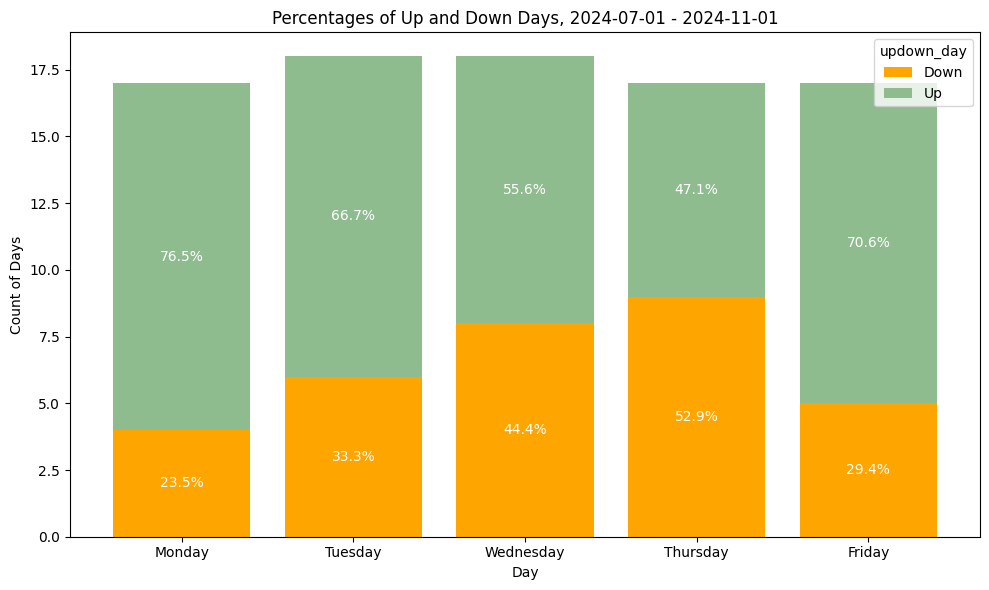

In [33]:
df_pvtDay = pd.DataFrame(df_pvtDay, index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

# Drop '% Up' column to focus on counts for 'Up' and 'Down'
df_pvtDay_plot = df_pvtDay.drop(columns='% Up')

# Calculate percentage for each category within each day (row-wise)
df_pvtDay_percent = df_pvtDay_plot.div(df_pvtDay_plot.sum(axis=1), axis=0) * 100

color_map = ['orange', 'darkseagreen']


# Plotting the pivot table as a stacked bar chart
ax = df_pvtDay_plot.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, color=color_map)

# Adding percentage labels within each bar segment
for i, bar_group in enumerate(ax.containers):
    for j, bar in enumerate(bar_group):
        # Only label bars with a non-zero height
        height = bar.get_height()
        if height > 0:
            # Position the percentage label in the center of each bar segment
            x_position = bar.get_x() + bar.get_width() / 2
            y_position = bar.get_y() + height / 2

            # Retrieve the percentage value from df_pvtDay_percent
            percentage = df_pvtDay_percent.iloc[j, i]

            # Display the percentage inside each bar segment
            ax.text(
                x_position, y_position,  # Position in the center of the segment
                f'{percentage:.1f}%',  # Format to 1 decimal place
                ha='center', va='center', color='white', fontsize=10
            )

# Adding titles and labels
plt.title(f'Percentages of Up and Down Days, {date_filter_start} - {end_date}')
plt.xlabel('Day')
plt.ylabel('Count of Days')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal for readability

# Show the plot
plt.tight_layout()
plt.show()

### Chart Showing Per Month Breakdown Of Up And Down Days - YTD
Second half of the year trending more bullish then earlier in the year. 


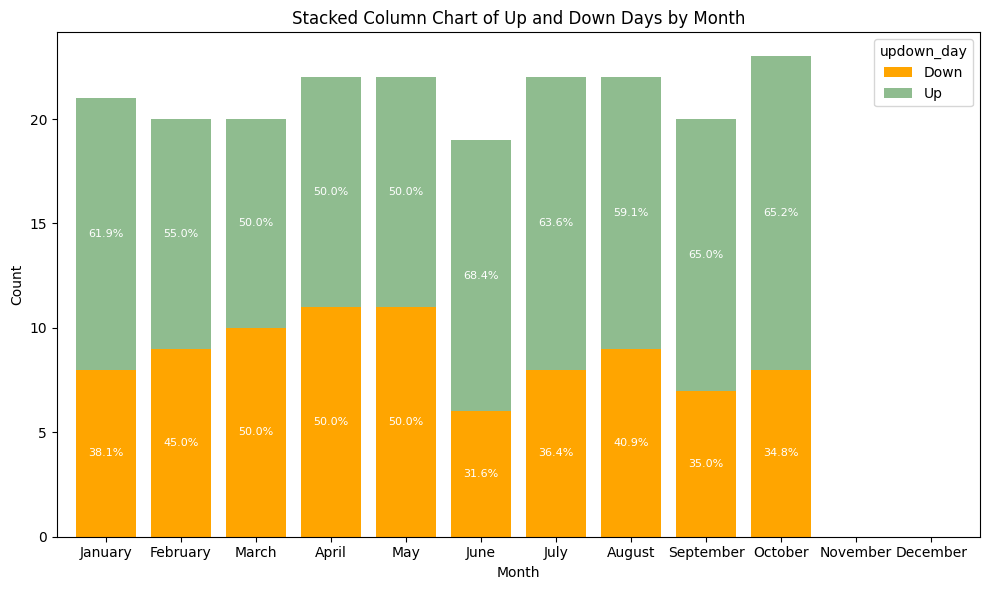

In [34]:
# Drop the '% Up' column from df_pvtMonth if it exists
df_pvtMonth_plot = df_pvtMonth.drop(columns='% Up', errors='ignore')

# Calculate percentage for each category within each month (row-wise)
df_pvtMonth_percent = df_pvtMonth_plot.div(df_pvtMonth_plot.sum(axis=1), axis=0) * 100

# Plotting the pivot table as a stacked bar chart
color_map = ['orange', 'darkseagreen']
ax = df_pvtMonth_plot.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, color=color_map)

# Adding percentage labels inside each stacked bar section
for col_idx, bar_group in enumerate(ax.containers):
    for bar in bar_group:
        # Get the height of each bar section
        height = bar.get_height()
        if height > 0:  # Only add labels to non-zero bars
            # Calculate the cumulative position for each bar section in the stack
            cumulative_height = bar.get_y() + height / 2  # Center the text within each section

            # Retrieve the percentage value from df_pvtMonth_percent
            row_idx = int(bar.get_x() + 0.5)  # Row index (month)
            percentage = df_pvtMonth_percent.iloc[row_idx, col_idx]  # Access the correct percentage

            # Add percentage text inside the bar
            ax.text(
                bar.get_x() + bar.get_width() / 2, cumulative_height,  # Position inside the bar section
                f'{percentage:.1f}%',  # Format to 1 decimal place
                ha='center', va='center', color='white', fontsize=8  # White font for visibility
            )

# Adding titles and labels
plt.title('Stacked Column Chart of Up and Down Days by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep month labels horizontal for readability

# Show the plot
plt.tight_layout()  # Ensure the layout is nicely spaced
plt.show()

### Line Graph Showing Buy & Sell Signals Based On 5 & 7 Day Exponential Moving Averages (EMA).
When the 5 day EMA crosses above the 7 day EMA there is a higher chance of upward trend. <br>
When the 5 day EMA crosses below the 7 day EMA there is a higher chance of downward trend. 

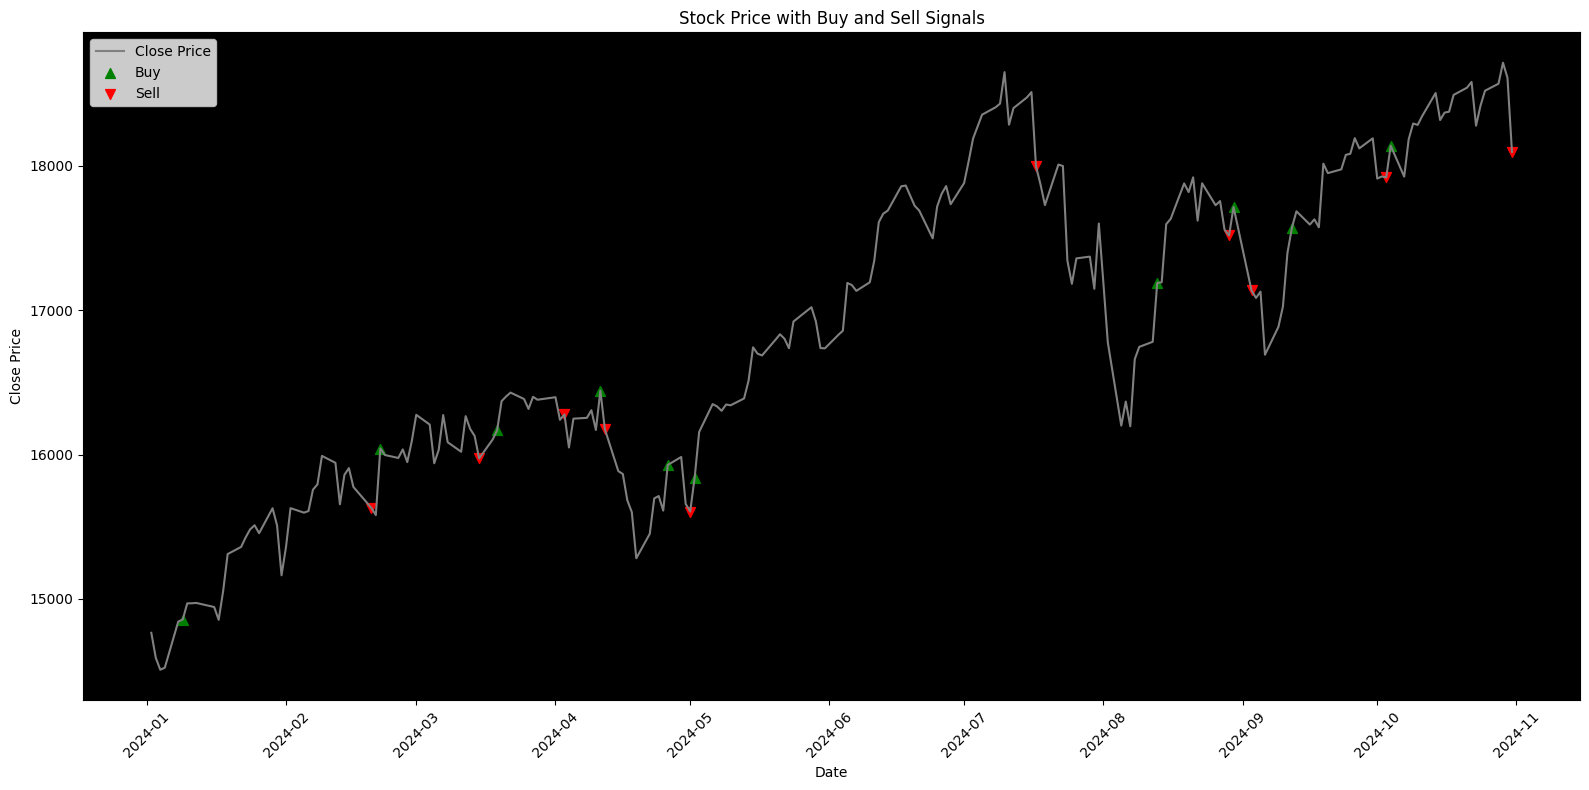

In [35]:
buy_signal = df['Signal'] == 'Buy'
sell_signal = df['Signal'] == 'Sell'

plt.figure(figsize=(16, 8))

# Plotting the line graph for 'Close' prices
plt.plot(df['Date'], df['Close'], label='Close Price', color='gray')

# Highlight buy signals in green
plt.scatter(df['Date'][buy_signal], df['Close'][buy_signal], marker='^', s=50, color='green', label='Buy')

# Highlight sell signals in red
plt.scatter(df['Date'][sell_signal], df['Close'][sell_signal], marker='v', s=50, color='red', label='Sell')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price with Buy and Sell Signals')
plt.legend()

plt.gca().set_facecolor('black')  # Set the background color to black

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The reason I use the 5 day moving average because it covers the whole weekend. It allows me to day trade with stocks, when to buy and sell stocks. <br>
The reason I use the 7 day moving average because it allows you to gain insights into future predictions on stock performance. <br>
Bullish day is tuesday with the 5 day moving average with wednesday, thursday, and friday following suit <br>
Bearish day is monday within 5 day moving average. 


git checkout staging => switch between branches.<BR>
git fetch origin => update your local repository with the latest changes from the remote branch<BR>
git pull origin staging => Merge the remote staging branch into your local staging branch<BR>
git add . => add all changes in the current directory<BR>
git push origin staging